## sprint08 ニューラルネットワーク  
  
問題６で、class ScratchSimpleNeuralNetrowkClassifier2()を作成。

In [36]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.patches as patches
from sklearn.model_selection import train_test_split

pd.set_option('display.max_columns', 250)
np.set_printoptions(threshold=np.inf)
import tensorflow as tf

In [37]:
from keras.datasets import mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [38]:
### X_test y_testは使用しない？　###

X_train = X_train.reshape(-1, 784)
X_test = X_test.reshape(-1, 784)

X_train = X_train.astype(np.float)
X_test = X_test.astype(np.float)
X_train /= 255
X_test /= 255


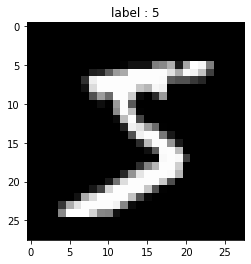

In [39]:
index = 0
image = X_train[index].reshape(28,28)
image = image.astype(np.float) # float型に変換
image = image
plt.imshow(image, 'gray')
# plt.imshow(image, 'gray' ,vmin = 0, vmax = 255)
plt.title('label : {}'.format(y_train[index]))
plt.show()
# print(image) # 値を確認

In [40]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
y_train_one_hot = enc.fit_transform(y_train[:, np.newaxis])
y_test_one_hot = enc.transform(y_test[:, np.newaxis])
#print(y_train.shape) # (60000,)
#print(y_train_one_hot.shape) # (60000, 10)
#print(y_train_one_hot.dtype) # float64

In [41]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train_one_hot, test_size=0.2)

In [51]:
class GetMiniBatch:
    """
    ミニバッチを取得するイテレータ

    Parameters
    ----------
    X : 次の形のndarray, shape (n_samples, n_features)
      訓練データ
    y : 次の形のndarray, shape (n_samples, 1)
      正解値
    batch_size : int
      バッチサイズ
    seed : int
      NumPyの乱数のシード
    """
    def __init__(self, X, y, batch_size = 20, seed=0):
        self.batch_size = batch_size
        np.random.seed(seed)
        shuffle_index = np.random.permutation(np.arange(X.shape[0]))
        self._X = X[shuffle_index]
        self._y = y[shuffle_index]
        self._stop = np.ceil(X.shape[0]/self.batch_size).astype(np.int)
    def __len__(self):
        return self._stop
    def __getitem__(self,item):
        p0 = item*self.batch_size
        p1 = item*self.batch_size + self.batch_size
        return self._X[p0:p1], self._y[p0:p1]        
    def __iter__(self):
        self._counter = 0
        return self
    def __next__(self):
        if self._counter >= self._stop:
            raise StopIteration()
        p0 = self._counter*self.batch_size
        p1 = self._counter*self.batch_size + self.batch_size
        self._counter += 1
        return self._X[p0:p1], self._y[p0:p1]

## 【問題1】重みの初期値を決めるコードの作成  
ニューラルネットワークの各層の重みの初期値を決めるコードを作成してください。

In [145]:
n_nodes = [400,200]
n_features = 784
target_num = 10
sigma = 0.01

w1 = np.random.randn(n_features, n_nodes[0])*sigma
w2 = np.random.randn(n_nodes[0],n_nodes[1])*sigma
w3 = np.random.randn(n_nodes[1],target_num)*sigma

b1 = np.random.randn(n_nodes[0])*sigma
b2 = np.random.randn(n_nodes[1])*sigma
b3 = np.random.randn(target_num)*sigma

print(b1.shape,b2.shape,b3.shape)

(400,) (200,) (10,)


## 【問題2】フォワードプロパゲーションの実装

In [146]:
def f_propagation(x,w,b, activation="sigmoid"):
    A = np.dot(x,w) + b
    if activation == "sigmoid":
        Z = 1/(1 + np.exp(-A))
    elif activation == "htan":  
        Z = (exp(A)-exp(-A))/(exp(A)+exp(-A))
    elif activation == "softmax":
        Z = (np.exp(A))/(np.sum(np.exp(A),axis=1)).reshape(-1,1)
    return Z,A

In [147]:
Z1,A1 = f_propagation(X_train[0:20,:],w1,b1,"sigmoid")
Z2,A2 = f_propagation(Z1,w2,b2,"sigmoid")
Z3,A3 = f_propagation(Z2,w3,b3,"softmax")
Z3.shape

(20, 10)

## 【問題3】交差エントロピー誤差の実装

In [148]:
def object_func(label_array,ff_output):
    ## label_arrayはバッチ内の１Ｈエンコードのターゲットデータ。ff_outputはフィードフォワードの結果。（行：サンプル数、列：ラベル数）
    c_entropy = -1/len(label_array)*np.sum(label_array*np.log(ff_output))
    return c_entropy

In [149]:
ff_output = Z3
label_array = y_train_one_hot[0:20,:]

print(object_func(label_array,ff_output))

2.307997953734747


## 【問題4】バックプロパゲーションの実装  

In [150]:
target = y_train_one_hot[0:20,:]
ff_output = Z3
lr = 0.02

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

delta1 = ff_output - target
delta2 = ((1-sigmoid(A2))*sigmoid(A2))*(np.dot(delta1,w3.T))
delta3 = ((1-sigmoid(A1))*sigmoid(A1))*(np.dot(delta2,w2.T))

def backpro_bias(b,lr,delta):
    b_new = b - lr * np.mean(delta,axis=0)
    return b_new

def backpro_coef(w,lr,under_output,delta):    
    w_new = w - lr * np.dot(under_output.T,delta)
    return  w_new

b3_new = backpro_bias(b3,lr,delta1)
b2_new = backpro_bias(b2,lr,delta2)
b1_new = backpro_bias(b1,lr,delta3)
w3_new = backpro_coef(w3, lr, Z2, delta1)
w2_new = backpro_coef(w2, lr, Z1, delta2)
w1_new = backpro_coef(w1, lr, X_train[0:20], delta3)

print(delta1.shape,delta2.shape,delta3.shape)
print(b1_new.shape,b2_new.shape,b3_new.shape)
print(w1_new.shape,w2_new.shape,w3_new.shape)

(20, 10) (20, 200) (20, 400)
(400,) (200,) (10,)
(784, 400) (400, 200) (200, 10)


## 【問題5】推定

## 【問題6】学習と推定 （イタレーション数はfit関数内で入力）

In [153]:
class ScratchSimpleNeuralNetrowkClassifier2():

    def __init__(self, verbose = True):
        self.verbose = verbose    
    
    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def f_propagation(self,x,w,b, activation="sigmoid"):
        A = np.dot(x,w) + b
        if activation == "sigmoid":
            Z = 1/(1 + np.exp(-A))        
        elif activation == "tanh":  
            Z = (np.exp(A)-np.exp(-A))/(np.exp(A)+np.exp(-A))
        elif activation == "softmax":
            Z = (np.exp(A.T))/np.sum(np.exp(A),axis=1)
            Z = Z.T
        return Z,A

    def backpro_bias(self,b,lr,delta):
        b_new = b - lr * np.sum(delta,axis=0)   ### mean
        return b_new
    def backpro_coef(self,w,lr,under_output,delta): 
        w_new = w - lr * np.dot(under_output.T, delta)
        return  w_new
    
    def object_func(self,y,z):
        c_entropy = -1/len(y)*np.sum(y*np.log(z))
        return c_entropy
    
    def fit(self,X, y):
        
        n_nodes = [400,200]
        n_features = 784
        target_num = 10
        sigma = 0.01
        
        self.w1 = np.random.randn(n_features, n_nodes[0])*sigma
        self.w2 = np.random.randn(n_nodes[0],n_nodes[1])*sigma
        self.w3 = np.random.randn(n_nodes[1],target_num)*sigma        
        self.b1 = np.random.randn((n_nodes[0]))*sigma
        self.b2 = np.random.randn((n_nodes[1]))*sigma
        self.b3 = np.random.randn((target_num))*sigma
        
        get_mini_batch = GetMiniBatch(X, y)
        lr = 0.02
        
        #### イタレーション数の入力 ###
        iter_num = 2
        self.c_entropy = np.zeros(iter_num)
        
        for i in range(iter_num):
            for mini_X_train, mini_y_train in get_mini_batch:
                Z1,A1 = self.f_propagation(mini_X_train, self.w1, self.b1,"sigmoid")
                Z2,A2 = self.f_propagation(Z1, self.w2, self.b2, "sigmoid")
                Z3,A3 = self.f_propagation(Z2, self.w3, self.b3,"softmax")

                delta1 =  Z3 - mini_y_train
                delta2 = ((1-self.sigmoid(A2))*self.sigmoid(A2))*(np.dot(delta1, self.w3.T))
                delta3 = ((1-self.sigmoid(A1))*self.sigmoid(A1))*(np.dot(delta2, self.w2.T))
                
                self.b3 = self.backpro_bias(self.b3,lr,delta1)
                self.b2 = self.backpro_bias(self.b2,lr,delta2)
                self.b1 = self.backpro_bias(self.b1,lr,delta3)
                self.w3 = self.backpro_coef(self.w3, lr, Z2, delta1)
                self.w2 = self.backpro_coef(self.w2, lr, Z1, delta2)
                self.w1 = self.backpro_coef(self.w1, lr, mini_X_train, delta3)
                      
            Z1,A1 = self.f_propagation(X, self.w1, self.b1, "sigmoid")
            Z2,A2 = self.f_propagation(Z1, self.w2, self.b2,"sigmoid")
            Z3,A3 = self.f_propagation(Z2, self.w3, self.b3,"softmax")
        
            self.c_entropy[i] = self.object_func(y,Z3)

        print(self.c_entropy)

    def predict(self, X):
        Z1,A1 = self.f_propagation(X, self.w1, self.b1, "sigmoid")
        Z2,A2 = self.f_propagation(Z1, self.w2, self.b2,"sigmoid")
        Z3,A3 = self.f_propagation(Z2, self.w3, self.b3,"softmax")
        pred = np.argmax(Z3,axis=1)
        return pred

In [128]:
## 5回のイタレーションでの学習モデルフィッティング ##
clf2 = ScratchSimpleNeuralNetrowkClassifier2()
clf2.fit(X_train, y_train)

[0.82757798 0.29105773 0.19208006 0.14245117 0.11711574]


In [129]:
## 5回のイタレーションでのクロスエントロピー ##
clf2.c_entropy

array([0.82757798, 0.29105773, 0.19208006, 0.14245117, 0.11711574])

In [131]:
## 推定結果の出力 ##
clf2.predict(X_test[0:100])

array([7, 2, 1, 0, 4, 1, 4, 9, 6, 9, 0, 6, 9, 0, 1, 5, 9, 7, 3, 4, 9, 6,
       6, 5, 4, 0, 7, 4, 0, 1, 3, 1, 3, 4, 7, 2, 7, 1, 2, 1, 1, 7, 4, 2,
       3, 5, 1, 2, 4, 4, 6, 3, 5, 5, 6, 0, 4, 1, 9, 5, 7, 8, 9, 3, 7, 4,
       6, 4, 3, 0, 7, 0, 2, 9, 1, 7, 3, 2, 9, 7, 7, 6, 2, 7, 8, 4, 7, 3,
       6, 1, 3, 6, 9, 3, 1, 4, 1, 7, 6, 9], dtype=int64)

In [130]:
##　accuracyの計算　##
from sklearn.metrics import accuracy_score
accuracy_score(y_test, clf2.predict(X_test))

0.9572

## 【問題7】学習曲線のプロット

In [133]:
##　15回のイタレーション回数での学習曲線プロット ##
clf2 = ScratchSimpleNeuralNetrowkClassifier2()
clf2.fit(X_train, y_train)

[0.82757798 0.29105773 0.19208006 0.14245117 0.11711574 0.10198044
 0.09339294 0.08611677 0.07563769 0.06391929 0.05372948 0.04555398
 0.03856558 0.03419757 0.03021526]


Text(0, 0.5, 'cross_entropy')

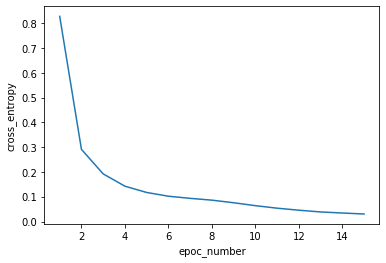

In [144]:
X_axis = range(1,16)
Y_axis = clf2.c_entropy
plt.plot(X_axis, Y_axis)
plt.xlabel("epoc_number")
plt.ylabel("cross_entropy")